# Modelling the OLG Model

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [2]:
from types import SimpleNamespace
from scipy import optimize
import numpy as np
import sympy as sm
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2



# Model description

We consider an OLG economy where identical competitive firms maximize their profits:

$$
\begin{aligned}
\pi_t & =\max_{K_{t},L_t} AK_t^\alpha L_t^{1-\alpha}-r_tK_t-w_tL_t\\
k_t=\frac{K_t}{L_t} 
\end{aligned}
$$

We use, that 
$$
\begin{aligned}
r_t = \alpha A k_t^{\alpha-1} \\
w_t = (1-\alpha) A k_t^{\alpha}
\end{aligned}
$$

**Demographics:** Population is constant, so $L_t=L_{t+1}$. A life consists of
two periods, *young* and *old*.

**Households:** Utility for the young households is:
    
$$
\begin{aligned}
U_t & = \log(c_{1t})+\frac{1}{1+\rho} \log(c_{2t+1})\\
\end{aligned}
$$

With the following budget constraints for a Pay As You Go (PAYG) system:
$$
\begin{aligned}
c_{1t} = (1-\tau)w_t-s_t
\\
c_{2t+1} = (1+r_{t+1})s_t+w_{t+1}\tau
\end{aligned}
$$

Budget constraints for fully funded (FF) system:
$$
\begin{aligned}
C_{1t} = (1-\tau)w_t-s_t
\\
C_{2t+1} = (1+r_{t+1})(s_t+w_t\tau)
\end{aligned}
$$

**Steady state:**

1. Find Euler equation
2. Find $s_t$ in the Euler equation by inserting the budget constraints, then $r_{t}, r_{t+1}, w_t, w_{t+1}$ and at last isolate $s_t$
3. Find capital per. capita accumulation: $k_{t+1}=(1-\delta)k_t+s_t$
4. In steady state $k_{t+1}=k_{t}=k^{*}$

**Capital:** We assume that the old spend their entrie savings, so $\delta = 1 $.

## Analytical solution for PAYG system

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

In [157]:
#define symbols 
alpha = sm.symbols('alpha')
k_t = sm.symbols('k_t')
k_t1 = sm.symbols('k_{t+1}')
k_ss = sm.symbols('k^*')
A = sm.symbols('A')
w_t = sm.symbols('w_t')
w_t1 = sm.symbols('w_{t+1}') 
r_t = sm.symbols('r_{t+1}')
r_t1 = sm.symbols('r_{t+1}')
s_t = sm.symbols('s_t') 
tau = sm.symbols('tau')
c_1t = sm.symbols('c_1t') 
c_2t = sm.symbols('c_{2t+1}') 
rho = sm.symbols('rho') 
lambdaa = sm.symbols('lambda')
U_t = sm.symbols('U_t')

#define rent and wage in period t and t+1
rent_t = alpha*A*k_t**(alpha-1)
rent_t1 = alpha*A*k_t1**(alpha-1)
wage_t = (1-alpha)*A*k_t**alpha
wage_t1 = (1-alpha)*A*k_t1**alpha

**Euler equation:**

In [159]:
#define utility function and budget constraints
u = sm.log(c_1t) + 1/(1+rho)*sm.log(c_2t)
con1 = sm.Eq(c_1t+s_t, (1-tau)*w_t)
con2_payg = sm.Eq(c_2t, (1+r_t1)*s_t+tau*w_t1)

#isolate s_t in con2 and substitute it into con1, so we end up with one budget constraint
st_con2 = sm.solve(con2_payg, s_t)
con1_sub = con1.subs(s_t, st_con2[0])

# Move right side of budget constraint to the left side
con_final = sm.solve(con1_sub, (1-tau)*w_t)[0] - (1-tau)*w_t

#Define lagrangian function with u and con_final
lagrangian_func = u - lambdaa*con_final

#Take the derivative wrt. c_1t and c_2t
foc1 = sm.diff(lagrangian_func, c_1t)
foc2 = sm.diff(lagrangian_func, c_2t)

#isolate lambdaa in foc1 and in foc2
iso_foc1 = sm.solve(foc1,lambdaa)[0]
iso_foc2 = sm.solve(foc2,lambdaa)[0]

#set the two isolate lamdaa equal to each other, so we get the Euler equation
euler = sm.Eq(iso_foc1,iso_foc2)
final_euler = sm.Eq(c_1t,sm.solve(euler,c_1t)[0])
print('Euler Equation:')
final_euler


Euler Equation:


Eq(c_1t, c_{2t+1}*(rho + 1)/(r_{t+1} + 1))

**Savings $(s_t)$**: From Euler equation


In [161]:
#isolate c_1t and c_2t in budget constraints and substitute it into Euler equation 
iso_con1 = sm.solve(con1,c_1t)[0]
iso_con2_payg = sm.solve(con2_payg,c_2t)[0]
savings = final_euler.subs(c_1t,iso_con1).subs(c_2t, iso_con2_payg)

#isolate s_t in savings
final_savings = sm.Eq(s_t, sm.solve(savings,s_t)[0])
simp_final_savings = sm.simplify(final_savings)
print('Savings:')
simp_final_savings

Savings:


Eq(s_t, (-r_{t+1}*tau*w_t + r_{t+1}*w_t - rho*tau*w_{t+1} - tau*w_t - tau*w_{t+1} + w_t)/(r_{t+1}*rho + 2*r_{t+1} + rho + 2))

We would liked to have a more simplified $s_t$ like 
$$
\begin{aligned}
s_t = \frac{1-\rho}{2+\rho}w_t - \tau \frac{1+\rho}{(2+\rho)(1+r_{t+1})}w_{t+1}
\end{aligned}
$$
but sympy dont do that. They are still the same tho, one is just more simplified.

**Capital accumulation**: from savings as $s_t=k_{t+1}$

In [162]:
#substitute s_t with k_t1
cap_acc = final_savings.subs(s_t,k_t1)

#substitute w_t, w_t1 and r_t1 with wage_t, wage_t1 and rent_t1
sub_cap_acc = ((cap_acc.subs(w_t,wage_t)).subs(w_t1,wage_t1)).subs(r_t1,rent_t1)
w_1 = cap_acc.subs(w_t,wage_t)
#isolate k_t1, but sympy can't do it since it did not simplifed final_savings
"final_cap_acc = sm.solve(sub_cap_acc,k_t1)[0]"

#Instead we show
print('almost capital accumulation:')
sub_cap_acc


almost capital accumulation


Eq(k_{t+1}, (-A**2*alpha*k_t**alpha*k_{t+1}**(alpha - 1)*tau*(1 - alpha) + A**2*alpha*k_t**alpha*k_{t+1}**(alpha - 1)*(1 - alpha) - A*k_t**alpha*tau*(1 - alpha) + A*k_t**alpha*(1 - alpha) - A*k_{t+1}**alpha*rho*tau*(1 - alpha) - A*k_{t+1}**alpha*tau*(1 - alpha))/(A*alpha*k_{t+1}**(alpha - 1)*rho + 2*A*alpha*k_{t+1}**(alpha - 1) + rho + 2))

If sympy could have isolated k_t1 in sub_cap_acc, then we would have gotten a very complex edition of 
$$
\begin{aligned}
k_{t+1} = \frac{(1-\alpha)(1-\tau)\alpha}{(2+\rho)\alpha+(1+\rho)(1-\alpha)\tau}A k_t^\alpha 
\end{aligned}
$$
, but they would still be the same.

We will go by the simplified capital accumulation above for the rest of the project

In [163]:
final_cap_acc = sm.Eq(k_t1, (1-alpha)*(1-tau)*alpha/((2+rho)*alpha+(1+rho)*(1-alpha)*tau)*A*k_t**alpha)
print('Capital accumulation:')
final_cap_acc

Capital accumulation:


Eq(k_{t+1}, A*alpha*k_t**alpha*(1 - alpha)*(1 - tau)/(alpha*(rho + 2) + tau*(1 - alpha)*(rho + 1)))

**Steady State**: From capital accumulation as $k_{t+1}=k_t=k^*$

In [164]:
#substitute k_t1 and k_t with k_ss
ss = (final_cap_acc.subs(k_t1,k_ss)).subs(k_t,k_ss)

#isolate k_ss
final_ss = sm.Eq(k_ss, sm.solve(ss,k_ss)[0])
print('Steady state:')
final_ss

Steady state:


Eq(k^*, ((-alpha*rho*tau + alpha*rho - alpha*tau + 2*alpha + rho*tau + tau)/(A*alpha*(alpha*tau - alpha - tau + 1)))**(1/(alpha - 1)))

## Numerical solution

In [165]:
#Define parameters
alpha = 0.3
rho = 0.25
tau = 0.2
A = 10

#we let $k_t$ be in [0,50]
k_t = np.linspace(0,50)

#We define capital accumulation and steady state
k_t1 = ((1-alpha)*(1-tau)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau)*A*k_t**alpha

ss_k = ((-alpha*rho*tau+alpha*rho-alpha*tau+2*alpha+rho*tau+tau)/(A*alpha*(alpha*tau-alpha-tau+1)))**(1/(alpha-1))



<function matplotlib.pyplot.show(close=None, block=None)>

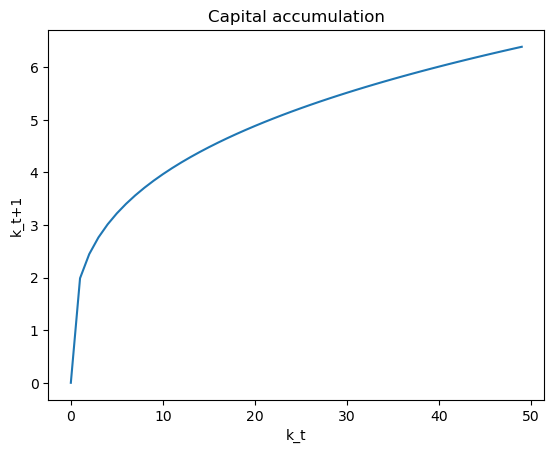

In [166]:
#Create plot
plt.plot(k_t1)
plt.title('Capital accumulation')
plt.ylabel('k_t+1')
plt.xlabel('k_t')
plt.show

In [167]:
#calulate steady state
print('steady state:')
print(ss_k)


steady state:
2.6466743507046537


**Capital accumulation and steady state with different tau-values**

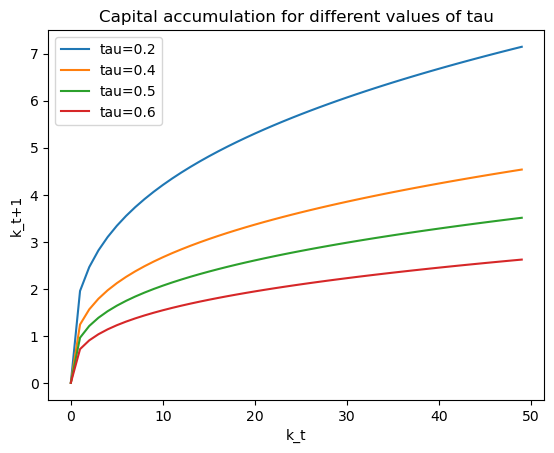

In [171]:
#define parameter values with multiple values of tau

alpha = 1/3
tau1 = 0.2
tau2 = 0.4
tau3 = 0.5
tau4 = 0.6
rho = 0.25
A = 10
k_t = np.linspace(0,50)

#define capital accumulation with different values of tau
k_t1_1 = ((1-alpha)*(1-tau1)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau1)*A*k_t**alpha
k_t1_2 = ((1-alpha)*(1-tau2)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau2)*A*k_t**alpha
k_t1_3 = ((1-alpha)*(1-tau3)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau3)*A*k_t**alpha
k_t1_4 = ((1-alpha)*(1-tau4)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau4)*A*k_t**alpha

#define steady state with different values of tau
ss_k_2 = ((-alpha*rho*tau2+alpha*rho-alpha*tau2+2*alpha+rho*tau2+tau2)/(A*alpha*(alpha*tau2-alpha-tau2+1)))**(1/(alpha-1))
ss_k_3 = ((-alpha*rho*tau3+alpha*rho-alpha*tau3+2*alpha+rho*tau3+tau3)/(A*alpha*(alpha*tau3-alpha-tau3+1)))**(1/(alpha-1))
ss_k_4 = ((-alpha*rho*tau4+alpha*rho-alpha*tau4+2*alpha+rho*tau4+tau4)/(A*alpha*(alpha*tau4-alpha-tau4+1)))**(1/(alpha-1))

#Create plot with the four different capital accumulation
plt.plot(k_t1_1, label='tau=0.2')
plt.plot(k_t1_2, label='tau=0.4')
plt.plot(k_t1_3, label='tau=0.5')
plt.plot(k_t1_4, label='tau=0.6')
plt.title('Capital accumulation for different values of tau')
plt.xlabel("k_t")
plt.ylabel("k_t+1")
plt.legend()
plt.show()

Steady state with different tau values

In [153]:
print('steady state where tau is 0.2:')
print(ss_k)

print('steady state where tau is 0.4:')
print(ss_k_2)
print('steady state where tau is 0.5:')
print(ss_k_3)
print('steady state where tau is 0.6:')
print(ss_k_4)

steady state where tau is 0.2:
2.6466743507046537
steady state where tau is 0.4:
1.3654158676313333
steady state where tau is 0.5:
0.9294286409033652
steady state where tau is 0.6:
0.5996615414837816


You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

# Further analysis

We would like to also have done it with fully funded system, but we did not have time

# Conclusion

When the contribution, $\tau$ from the young households increase, then will capital per. capita in steady state decrease.
It happends because the increased contribution makes the young households save less and then capital decreses. 